In [1]:
import numpy as np
import cv2
import tensorflow as tf
import sklearn
from matplotlib import pyplot as plt
from shutil import copyfile
import shutil
import random
import albumentations as A
%matplotlib inline

2021-12-13 14:09:24.908021: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-13 14:09:24.908060: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [3]:
from os import listdir, mkdir, getcwd
from os.path import isfile, join

# Importing dataset paths

In [4]:
labels_path = "data/ai4mars-dataset-merged-0.1/msl/labels/train/"
imgs_path = "data/ai4mars-dataset-merged-0.1/msl/images/edr/"

labels_files = [f for f in listdir(labels_path) if isfile(join(labels_path, f))]
imgs_files = [f for f in listdir(imgs_path) if isfile(join(imgs_path, f))]

# Understanding dataset

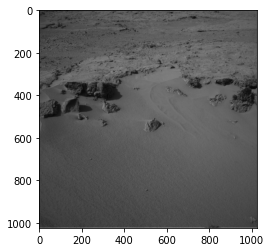

In [5]:
img = cv2.imread(imgs_path+"NLA_402736827EDR_F0050104NCAM00449M1.JPG")
plt.imshow(img)

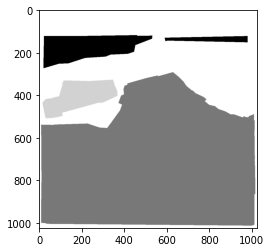

In [6]:
labels = cv2.imread(labels_path+"NLA_402736827EDR_F0050104NCAM00449M1.png")
labels[labels==0] = 0   #soil labels remain black
labels[labels==1] = 50  #bedrock labels in dark grey
labels[labels==2] = 120 #sand labels in light grey
labels[labels==3] = 210 #big_rock labels in broken white

plt.imshow(labels)

# Selecting images and cleaning labels with big rocks[3]

I will select a subset of images where big_rocks appear and another one where they don't appear. In this way, I will be able to create balanced datasets for training and testing.

I will label the background as 0 and the big_rocks as 1.

I will save the original images normalized to the [0,1] range.

In [7]:
len(labels_files)

16064

Selecting a subset of images from the AI4MARS data set as it's too big. I will run all the training, validation and testing with only one class(big_rocks) to
    to simplify the training computation. I also select some images where this object does not appear to make sure the NN also learns when this object is not in the image.
    (This was the first idea when developing this part but as I was running out of RAM while training I decided to include a few)

THIS CODE WILL NOT RUN IF THE "ONLY_ROCKK" FOLDERS ARE ALREADY CREATED. Run the cell bellow to delete the folders and then run this cell again with the max_image and label_id values desired.

In [8]:
max_images = 2000
label_id = 3
imgs_contain_rocks = []
labels_contain_rocks = []
imgs_contain_no_rocks = []
labels_contain_no_rocks = []

labels_only_rocks = "data/ai4mars-dataset-merged-0.1/msl/labels/only_rocks/"
imgs_only_rocks = "data/ai4mars-dataset-merged-0.1/msl/images/only_rocks/"

#randomly shuffled image names to make sure there is no order dependency
random.shuffle(labels_files)

count = 0
print(getcwd())
try:
    mkdir(labels_only_rocks)
except:
    print("Folder already exists")
    max_images = 0
    count = len(labels_files)
try:
    mkdir(imgs_only_rocks)
except:
    print("Folder already exists")
    max_images = 0
    count = len(labels_files)

while (len(imgs_contain_rocks) < max_images or len(imgs_contain_no_rocks) < max_images//10) and count < len(labels_files)-1:
    label_name = labels_files[count]
    labels = cv2.imread(labels_path+label_name)
    count += 1
    
    if label_id in np.unique(labels):
        if len(imgs_contain_rocks) < max_images:
            labels[labels!=label_id] = 255
            labels[labels==label_id] = 1
            labels[labels==255] = 0
            imgs_contain_rocks.append(imgs_only_rocks+label_name[:-4]+".JPG")
            labels_contain_rocks.append(labels_only_rocks+label_name)

            cv2.imwrite(labels_only_rocks+label_name, labels)
            copyfile(imgs_path+label_name[:-4]+".JPG", imgs_only_rocks+label_name[:-4]+".JPG")

    elif len(imgs_contain_no_rocks) < max_images//10:
        labels[labels!=label_id] = 0
        imgs_contain_no_rocks.append(imgs_only_rocks+label_name[:-4]+".JPG")
        labels_contain_no_rocks.append(labels_only_rocks+label_name)

        cv2.imwrite(labels_only_rocks+label_name, labels)
        copyfile(imgs_path+label_name[:-4]+".JPG", imgs_only_rocks+label_name[:-4]+".JPG")
    print("num_rocks: ", len(imgs_contain_rocks), "num_no_rocks", len(imgs_contain_no_rocks))

if max_images > 0:
    with open('src/contain_rocks/imgs_contain_no_rocks.txt', 'w') as f:
        for item in imgs_contain_no_rocks:
            f.write("%s\n" % item)

    with open('src/contain_rocks/labels_contain_no_rocks.txt', 'w') as f:
        for item in labels_contain_no_rocks:
            f.write("%s\n" % item)
        

    with open('src/contain_rocks/imgs_contain_rocks.txt', 'w') as f:
        for item in imgs_contain_rocks:
            f.write("%s\n" % item)

    with open('src/contain_rocks/labels_contain_rocks.txt', 'w') as f:
        for item in labels_contain_rocks:
            f.write("%s\n" % item)

/spaceapps_test
Folder already exists
Folder already exists


In [9]:
# shutil.rmtree(labels_only_rocks)
# shutil.rmtree(imgs_only_rocks)


# Splitting data into train, validation and test datasets

In [10]:
def split_dataset(num_imgs_rocks, num_imgs_no_rocks,split=0.6):
    """ 
        Splitting the dataset into the train, validation and test datasets. 
        It makes sure that there is the same distribution of all the classes appearances in all the different datasets.
    """
    imgs_contain_rocks = np.loadtxt('src/contain_rocks/imgs_contain_rocks.txt', dtype=str)
    labels_contain_rocks = np.loadtxt('src/contain_rocks/labels_contain_rocks.txt', dtype=str)
    labels_contain_no_rocks = np.loadtxt('src/contain_rocks/labels_contain_no_rocks.txt', dtype=str)
    imgs_contain_no_rocks = np.loadtxt('src/contain_rocks/imgs_contain_no_rocks.txt', dtype=str)

    num_rock_images_train = int(num_imgs_rocks * split)
    num_no_rock_images_train = int(num_imgs_no_rocks * split)

    indexes_rocks_train = random.sample(range(0, num_imgs_rocks), num_rock_images_train)
    indexes_rocks_no_train = np.setxor1d(range(0,num_imgs_rocks), indexes_rocks_train)
    indexes_rocks_validation = indexes_rocks_no_train[random.sample(range(0,len(indexes_rocks_no_train)), len(indexes_rocks_no_train)//2)]
    indexes_rocks_test = np.setxor1d(indexes_rocks_no_train, indexes_rocks_validation)

    indexes_no_rocks_train = random.sample(range(0, num_imgs_no_rocks), num_no_rock_images_train)
    indexes_no_rocks_no_train = np.setxor1d(range(0,num_imgs_no_rocks), indexes_no_rocks_train)
    indexes_no_rocks_validation = indexes_no_rocks_no_train[random.sample(range(0,len(indexes_no_rocks_no_train)), len(indexes_no_rocks_no_train)//2)]
    indexes_no_rocks_test = np.setxor1d(indexes_no_rocks_no_train, indexes_no_rocks_validation)

    imgs_paths_train = np.concatenate((imgs_contain_rocks[indexes_rocks_train], imgs_contain_no_rocks[indexes_no_rocks_train]))
    labels_paths_train = np.concatenate((labels_contain_rocks[indexes_rocks_train], labels_contain_no_rocks[indexes_no_rocks_train]))
    imgs_paths_test = np.concatenate((imgs_contain_rocks[indexes_rocks_test], imgs_contain_no_rocks[indexes_no_rocks_test]))
    labels_paths_test = np.concatenate((labels_contain_rocks[indexes_rocks_test], labels_contain_no_rocks[indexes_no_rocks_test]))
    imgs_paths_validation = np.concatenate((imgs_contain_rocks[indexes_rocks_validation], imgs_contain_no_rocks[indexes_no_rocks_validation]))
    labels_paths_validation = np.concatenate((labels_contain_rocks[indexes_rocks_validation], labels_contain_no_rocks[indexes_no_rocks_validation]))

    return imgs_paths_train, labels_paths_train, imgs_paths_test, labels_paths_test, imgs_paths_validation, labels_paths_validation

## Applying some data augmentation to the data
To the dataset used, some images are duplicated but transformed. The possible transformations that can be applied to the images are horizonal flip, brigthness and contrast, gaussian blur and sharppenning of the image.

This transformations will help the model to generalize more and be able to detect a similar object in different capturing conditions.

In [11]:
def apply_random_data_augmentation(img, labels, prob=0.5):
    if random.uniform(0,1) <= prob:
        transform = A.Compose([ A.HorizontalFlip(p=0.5),
                                A.RandomBrightnessContrast(p=0.2),
                                A.GaussianBlur(p=0.2),
                                A.Sharpen(p=0.2)
                                ])
        transformed = transform(image=img, mask=labels)
        return transformed['image'], transformed['mask']
    else:
        return np.array([]), np.array([])


## Loading selected images and apply the data augmentation

When this step is done, the data will be augmented according to the different transformations and split into training, validation and testing dataset. These 3 different 
datasets will have the same distribution of the classes in it.

The data it's being normalized to be in the [0,1] range.

In [12]:
def load_imgs_from_indexes(imgs_paths, labels_paths):
    """ 
        It loads the images, resize them and apply some data augmentation.
    """
    imgs_list = []
    labels_list = []
    for indx in random.sample(range(0, len(imgs_paths)), len(imgs_paths)):
        img_path = imgs_paths[indx]
        labels_path = labels_paths[indx]

        img_size = (128,128)
        img = cv2.resize(cv2.imread(img_path), img_size, interpolation = cv2.INTER_AREA)
        labels = cv2.resize(cv2.imread(labels_path)[:,:,0], img_size, interpolation = cv2.INTER_AREA)
        imgs_list.append(img/255)
        labels_list.append(labels)

        img_augm, labels_augm = apply_random_data_augmentation(img=img, labels=labels)
        if img_augm.shape[0] != 0:
            imgs_list.append(img_augm/255)
            labels_list.append(labels_augm)
    return imgs_list, labels_list

In [13]:
def load_data(split=0.6):
    imgs_contain_rocks = np.loadtxt('src/contain_rocks/imgs_contain_rocks.txt', dtype=str)
    labels_contain_rocks = np.loadtxt('src/contain_rocks/labels_contain_rocks.txt', dtype=str)
    labels_contain_no_rocks = np.loadtxt('src/contain_rocks/labels_contain_no_rocks.txt', dtype=str)
    imgs_contain_no_rocks = np.loadtxt('src/contain_rocks/imgs_contain_no_rocks.txt', dtype=str)

    imgs_paths_train, labels_paths_train, imgs_paths_test, labels_paths_test, imgs_paths_validation, \
        labels_paths_validation = split_dataset(len(imgs_contain_rocks), len(imgs_contain_no_rocks),split=split)
        
    
    #split the data set using the indexes and return 6 np.arrays of loaded images
    x_train, y_train = load_imgs_from_indexes(imgs_paths=imgs_paths_train, labels_paths=labels_paths_train)
    x_test, y_test = load_imgs_from_indexes(imgs_paths=imgs_paths_test, labels_paths=labels_paths_test)
    x_val, y_val = load_imgs_from_indexes(imgs_paths=imgs_paths_validation, labels_paths=labels_paths_validation)

    return x_train, y_train, x_test, y_test, x_val, y_val   
    

# Training model

In [14]:
#Following this tutorial https://segmentation-models.readthedocs.io/en/latest/tutorial.html
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_test, y_test, x_val, y_val = load_data(split=0.6)

x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
y_train = tf.cast(y_train, tf.float32)

x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)
y_test = tf.cast(y_test, tf.float32)

x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
y_val = tf.cast(y_val, tf.float32)

2021-12-13 14:10:10.946971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-13 14:10:10.946996: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-13 14:10:10.947017: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2021-12-13 14:10:10.947688: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-13 14:10:10.951468: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocatio

In [15]:
len(x_train)

1956

In [16]:
train_model = True
if train_model:
    # preprocess input
    X_train = preprocess_input(x_train)
    X_val = preprocess_input(x_val)

    shape = X_train[0].shape
    # define model
    model = Unet(BACKBONE, encoder_weights='imagenet', classes=1, input_shape=(shape[0], shape[1], shape[2]),encoder_freeze=True, activation='sigmoid')
    model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score, tf.keras.metrics.BinaryAccuracy()])

    # fit model
    model_history = model.fit(
                            x=X_train,
                            y=y_train,
                            batch_size=15,
                            epochs=20,
                            steps_per_epoch=len(X_train)/15,
                            validation_data=(X_val, y_val),
                        )
    model.save_weights('src/checkpoints3/my_checkpoint')

85532672/85521592 [==============================] - 2s 0us/step
Epoch 1/20
130/130 [==============================] - 160s 1s/step - loss: 1.1271 - iou_score: 0.0974 - binary_accuracy: 0.9249 - val_loss: 1.4597 - val_iou_score: 0.0043 - val_binary_accuracy: 0.9626
Epoch 2/20
130/130 [==============================] - 158s 1s/step - loss: 0.8970 - iou_score: 0.2220 - binary_accuracy: 0.9597 - val_loss: 1.2223 - val_iou_score: 0.0025 - val_binary_accuracy: 0.9626
Epoch 3/20
130/130 [==============================] - 161s 1s/step - loss: 0.8248 - iou_score: 0.2863 - binary_accuracy: 0.9658 - val_loss: 1.2925 - val_iou_score: 4.1830e-04 - val_binary_accuracy: 0.9626
Epoch 4/20
130/130 [==============================] - 159s 1s/step - loss: 0.7806 - iou_score: 0.3256 - binary_accuracy: 0.9691 - val_loss: 1.3262 - val_iou_score: 2.4446e-04 - val_binary_accuracy: 0.9626
Epoch 5/20
130/130 [==============================] - 161s 1s/step - loss: 0.7426 - iou_score: 0.3601 - binary_accuracy: 0.

### Training results

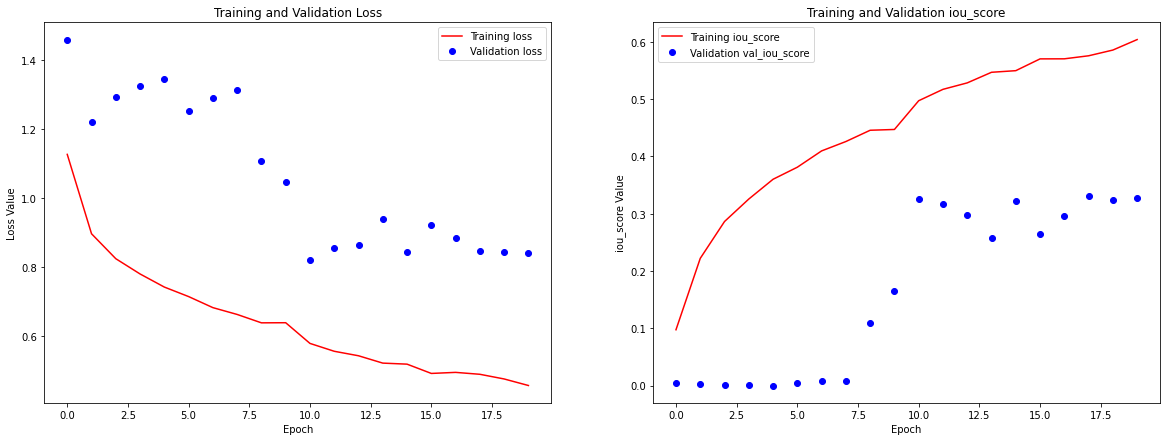

In [17]:
fig = plt.figure(figsize=(20,7))

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

iou_score = model_history.history['iou_score']
val_iou_score = model_history.history['val_iou_score']

plt.subplot(1, 2, 2)
plt.plot(model_history.epoch, iou_score, 'r', label='Training iou_score')
plt.plot(model_history.epoch, val_iou_score, 'bo', label='Validation val_iou_score')
plt.title('Training and Validation iou_score')
plt.xlabel('Epoch')
plt.ylabel('iou_score Value')
plt.legend()
plt.show()

# Testing the trained model

After 1h of training it was possible to get some representative results, that doesn't mean they are good. From the model_history plots shown previously it can be observed that the model can improve the performance if we would've trained for more iterations, but due to time and resources I decided to limited to 20 epochs.

In [18]:
import zipfile
with zipfile.ZipFile('src/checkpoints2.zip', 'r') as zip_ref:
    zip_ref.extractall('src/')

In [26]:
# Create a new model instance
model2 = Unet(BACKBONE, encoder_weights='imagenet', classes=1, input_shape=(shape[0], shape[1], shape[2]),encoder_freeze=True, activation='sigmoid')
model2.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score, tf.keras.metrics.BinaryAccuracy()])

# Restore the weights
model2.load_weights('src/checkpoints3/my_checkpoint')

In [35]:
eval_model = model.evaluate(x_test, y_test, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

21/21 - 9s - loss: 0.8384 - iou_score: 0.3076 - binary_accuracy: 0.9716 - 9s/epoch - 427ms/step


## Prediction from the training data set vs testing data set

We can see that either in the training data set and in the testing data set, with this short training, the model has been able to localize where the big_rocks are, even though it's missing quite a lot of detail that is gained by having longer trainings and more hyperparameter tunning.

Text(0.5, 1.0, 'prediction (train dataset)')

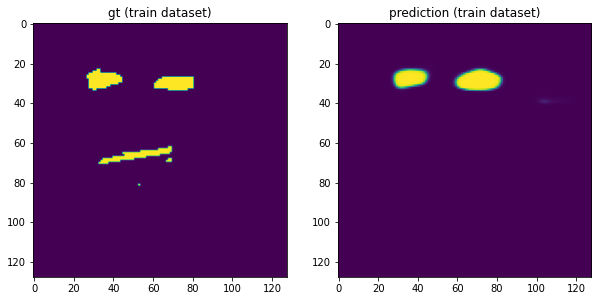

In [31]:
fig = plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.imshow(y_train[115])
plt.title("gt (train dataset)")

plt.subplot(1, 2, 2)
plt.imshow(model.predict(x_train[115:116])[0])
plt.title("prediction (train dataset)")

Text(0.5, 1.0, 'prediction (test dataset)')

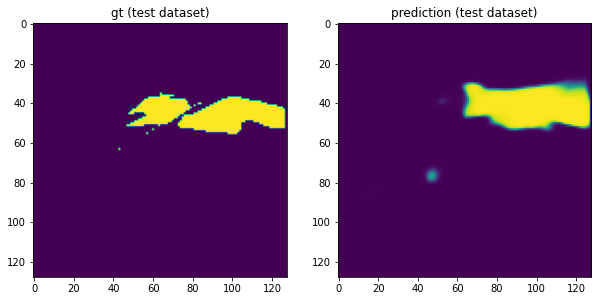

In [34]:
fig = plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.imshow(y_test[12])
plt.title("gt (test dataset)")

plt.subplot(1, 2, 2)
plt.imshow(model2.predict(x_test[12:13])[0])
plt.title("prediction (test dataset)")

# Conclusions and observations

As mentioned before, with a limited amount of time and using my own computer, the performance of the NN is not perfect on the testing/validation set. 
But if I would need to do the same task with more resources I would use more images for training, testing and validation, play around with the different learning rates, with the different batches sizes, play around with the data augmentation parameters to make sure we include the right amount of disturbance to the data set without lossing performance. Apart from playing with the initial parameters, I would also play with how dynamic I make them when the model reaches to the plateau region. 